In [73]:
import numpy as np
import pandas as pd
import geopandas as gpd

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbPipeline

import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


## Combining all the data

In [2]:
hfic = gpd.read_file('HFIC_new.geojson')

In [3]:
hfic.CS.value_counts()

1.0    3068
2.0    1498
3.0    1096
4.0     259
5.0       9
Name: CS, dtype: int64

In [4]:
gdf = gpd.read_file('wind_all.geojson')
other = gpd.read_file('light_in.geojson')

In [5]:
other['ozone_mean'] = other['ozone_mean'].fillna(other['ozone_mean'].median())
other['ozone_std'] = other['ozone_std'].fillna(other['ozone_std'].median())

In [6]:
## Merge
combo = gdf.join(other, rsuffix='_')

In [7]:
combo_m1 = combo[['ADM0_NAME', 'ADM1_CODE', 'CS', 'Start', 'End',  'Evap_tavg_', 'Evap_tavg_std_',
                   'Lwnet_tavg', 'Lwnet_tavg_std', 'Qair_f_tavg',
       'Qair_f_tavg_std', 'Qh_tavg', 'Qh_tavg_std', 
       'Qs_tavg', 'Qs_tavg_std', 'Rainf_f_tavg', 'Rainf_f_tavg_std',
       'SoilMoi00_10cm_tavg', 'SoilMoi00_10cm_tavg_std',
       'Swnet_tavg', 'Swnet_tavg_std',
       'Tair_f_tavg', 'Tair_f_tavg_std', 'Wind_f_tavg', 'Wind_f_tavg_std',
       'ozone_mean', 'ozone_std',
       'npp_mean', 'npp_std',  'nl_mean', 'nl_std',  'geometry']]

In [8]:
combo_m2 = combo.merge(hfic, on = ['ADM1_CODE', 'Start', 'End'], how = 'right')

In [9]:
combo_mod = combo_m2[['ADM0_NAME_x', 'ADM1_CODE','Start', 'End',  'Evap_tavg_', 'Evap_tavg_std_',
                      'Lwnet_tavg', 'Lwnet_tavg_std', 'Qair_f_tavg',
       'Qair_f_tavg_std', 'Qh_tavg', 'Qh_tavg_std', 'Qle_tavg', 'Qle_tavg_std',
       'Qs_tavg', 'Qs_tavg_std', 'Qsb_tavg', 'Qsb_tavg_std', 'RadT_tavg',
       'RadT_tavg_std', 'Rainf_f_tavg', 'Rainf_f_tavg_std',
       'SoilMoi00_10cm_tavg', 'SoilMoi00_10cm_tavg_std', 'SoilMoi10_40cm_tavg',
       'SoilMoi10_40cm_tavg_std', 'SoilTemp00_10cm_tavg',
       'SoilTemp00_10cm_tavg_std', 'SoilTemp10_40cm_tavg',
       'SoilTemp10_40cm_tavg_std', 'Swnet_tavg', 'Swnet_tavg_std',
       'Tair_f_tavg', 'Tair_f_tavg_std', 'Wind_f_tavg', 'Wind_f_tavg_std',
              'ozone_mean', 'ozone_std', 'npp_mean', 'npp_std', 'nl_mean',
       'nl_std', 'nl_dataset',
          'CS_y', 'geometry_x']]

In [10]:
combo_mod.CS_y.value_counts()

1.0    3068
2.0    1498
3.0    1096
4.0     259
5.0       9
Name: CS_y, dtype: int64

## First Model - Geophysical

In [11]:
X = combo_mod[['Evap_tavg_',
       'Lwnet_tavg',  'Qair_f_tavg',
        'Qh_tavg', 
       'Qs_tavg',   'Rainf_f_tavg', 
       'SoilMoi00_10cm_tavg', 'Swnet_tavg', 
       'Tair_f_tavg', 'Wind_f_tavg', 'ozone_mean',
       'npp_mean']]
y = combo_mod['CS_y']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

## Grid Search

In [139]:
pipeline_rf_gr = Pipeline([('classifier', RandomForestClassifier(random_state = 10))])

rf_params = {'classifier__n_estimators':[20, 50, 100, 200],
        'classifier__criterion':['gini', 'entropy'],
             'classifier__max_depth':[3, 5, 8, 10, 12],
             'classifier__min_samples_split':[2, 5, 8,10],
             'classifier__min_samples_leaf':[2, 5, 8]}
grid_rf = GridSearchCV(pipeline_rf_gr, rf_params, cv=5)

grid_rf.fit(X_train, y_train)

# Mirror Mirror from GridSearch! Tell me what's the best parameters
print(grid_rf.best_params_)

{'classifier__criterion': 'entropy', 'classifier__max_depth': 12, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}


In [140]:
clf=RandomForestClassifier(n_estimators=200, criterion = 'entropy', max_depth=12,
                        min_samples_leaf = 2, min_samples_split = 2,
                          random_state=10)
clf.fit(X_train,y_train)
y_pred_train = clf.predict(X_train)
y_pred=clf.predict(X_test)

In [141]:
print("Accuracy_test: %.3f%% " % (accuracy_score(y_test, y_pred)*100), 
     "Accuracy_train: %.3f%% " % (accuracy_score(y_train, y_pred_train)*100))

Accuracy_test: 63.250%  Accuracy_train: 94.333% 


### Note: Overfitting!

In [144]:
# Tunning to use less estimators and depth
clf=RandomForestClassifier(n_estimators=50, criterion = 'entropy', max_depth=10,
                        min_samples_leaf = 2, min_samples_split = 2,
                          random_state=10)
clf.fit(X_train,y_train)
y_pred_train = clf.predict(X_train)
y_pred=clf.predict(X_test)

In [145]:
print("Accuracy_test: %.3f%% " % (accuracy_score(y_test, y_pred)*100), 
     "Accuracy_train: %.3f%% " % (accuracy_score(y_train, y_pred_train)*100))

Accuracy_test: 62.846%  Accuracy_train: 83.989% 


## XGBoost

In [23]:
model = XGBClassifier(n_estimators = 30, objective='softmax', subsample = 0.55,
            max_depth = 5, seed = 10)
model.fit(X_train, y_train)
# make predictions for test data
y_pred_train = model.predict(X_train)
y_pred= model.predict(X_test)
print("Accuracy_test: %.3f%% " % (accuracy_score(y_test, y_pred)*100), 
     "Accuracy_train: %.3f%% " % (accuracy_score(y_train, y_pred_train)*100),
'Overfitting: %.3f%% ' % ((accuracy_score(y_test, y_pred)*100)-(accuracy_score(y_train, y_pred_train)*100)))

Accuracy_test: 62.980%  Accuracy_train: 69.170%  Overfitting: -6.190% 


## Second Model - Adding in Nightlight

In [24]:
X = combo_mod[['Evap_tavg_',
       'Lwnet_tavg',  'Qair_f_tavg',
        'Qh_tavg', 
       'Qs_tavg',   'Rainf_f_tavg', 
       'SoilMoi00_10cm_tavg', 'Swnet_tavg', 
       'Tair_f_tavg', 'Wind_f_tavg', 'ozone_mean',
       'npp_mean', 'nl_mean']]
y = combo_mod['CS_y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

In [148]:
pipeline_rf_gr = Pipeline([('classifier', RandomForestClassifier(random_state = 10))])

rf_params = {'classifier__n_estimators':[20, 50, 100, 200],
        'classifier__criterion':['gini', 'entropy'],
             'classifier__max_depth':[3, 5, 8, 10, 12],
             'classifier__min_samples_split':[2, 5, 8,10],
             'classifier__min_samples_leaf':[2, 5, 8]}
grid_rf = GridSearchCV(pipeline_rf_gr, rf_params, cv=5)

grid_rf.fit(X_train, y_train)

# Mirror Mirror from GridSearch! Tell me what's the best parameters
print(grid_rf.best_params_)

{'classifier__criterion': 'entropy', 'classifier__max_depth': 12, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}


In [153]:
clf=RandomForestClassifier(n_estimators=100, criterion = 'entropy', max_depth=8,
                        min_samples_leaf = 2, min_samples_split = 5,
                          random_state=10)
clf.fit(X_train,y_train)
y_pred_train = clf.predict(X_train)
y_pred=clf.predict(X_test)

In [154]:
print("Accuracy_test: %.3f%% " % (accuracy_score(y_test, y_pred)*100), 
     "Accuracy_train: %.3f%% " % (accuracy_score(y_train, y_pred_train)*100))

Accuracy_test: 61.834%  Accuracy_train: 73.038% 


(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, '1'), Text(0, 1.5, '2'), Text(0, 2.5, '3'), Text(0, 3.5, '4')])

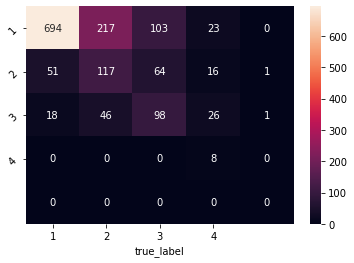

In [155]:
mat_r = confusion_matrix(y_test, y_pred)
sns.heatmap(mat_r.T, annot=True, fmt='g',
           xticklabels = ['1', '2', '3', '4'],
           yticklabels = ['1', '2', '3', '4'])
pl.xlabel('true_label')
pl.yticks(rotation = 45)

In [156]:
test_rp = classification_report(y_test, y_pred)
print(test_rp)

              precision    recall  f1-score   support

         1.0       0.67      0.91      0.77       763
         2.0       0.47      0.31      0.37       380
         3.0       0.52      0.37      0.43       265
         4.0       1.00      0.11      0.20        73
         5.0       0.00      0.00      0.00         2

    accuracy                           0.62      1483
   macro avg       0.53      0.34      0.35      1483
weighted avg       0.61      0.62      0.58      1483



/Users/lavz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lavz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lavz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
model = XGBClassifier(n_estimators = 30, objective='softmax', subsample = 0.55,
            max_depth = 5, seed = 10)
model.fit(X_train, y_train)
# make predictions for test data
y_pred_train = model.predict(X_train)
y_pred= model.predict(X_test)
print("Accuracy_test: %.3f%% " % (accuracy_score(y_test, y_pred)*100), 
     "Accuracy_train: %.3f%% " % (accuracy_score(y_train, y_pred_train)*100),
'Overfitting: %.3f%% ' % ((accuracy_score(y_test, y_pred)*100)-(accuracy_score(y_train, y_pred_train)*100)))

Accuracy_test: 63.722%  Accuracy_train: 70.632%  Overfitting: -6.910% 


## Third Model - Using Standard Error instead of Mean

In [26]:
x = []
for i in combo_mod['ozone_std']:
    if i > 0:
        x.append(i)

In [27]:
min(x)

2.85868460917316e-06

In [28]:
combo_mod['ozone_std'] = combo_mod['ozone_std'].replace(0, min(x))

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [29]:
combo_mod['Evap_se'] = combo_mod['Evap_tavg_']/combo_mod['Evap_tavg_std_']
combo_mod['Lwnet_se'] = combo_mod['Lwnet_tavg']/combo_mod['Lwnet_tavg_std']
combo_mod['Qair_se'] = combo_mod['Qair_f_tavg']/combo_mod['Qair_f_tavg_std']
combo_mod['Qh_se'] = combo_mod['Qh_tavg']/combo_mod['Qh_tavg_std']
combo_mod['Qs_se'] = combo_mod['Qs_tavg']/combo_mod['Qs_tavg_std']
combo_mod['Rainf_se'] = combo_mod['Rainf_f_tavg']/combo_mod['Rainf_f_tavg_std']
combo_mod['SoilMois_se'] = combo_mod['SoilMoi00_10cm_tavg']/combo_mod['SoilMoi00_10cm_tavg_std']
combo_mod['Swnet_se'] = combo_mod['Swnet_tavg']/combo_mod['Swnet_tavg_std']
combo_mod['Tair_se'] = combo_mod['Tair_f_tavg']/combo_mod['Tair_f_tavg_std']
combo_mod['Wind_se'] = combo_mod['Wind_f_tavg']/combo_mod['Wind_f_tavg_std']
combo_mod['Ozone_se'] = combo_mod['ozone_mean']/combo_mod['ozone_std']
combo_mod['npp_se'] = combo_mod['npp_mean']/combo_mod['npp_std']
combo_mod['nl_se'] = combo_mod['nl_mean']/combo_mod['nl_std']

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

In [30]:
X_se = combo_mod[['Evap_se','Lwnet_se',  'Qair_se',
        'Qh_se', 'Qs_se',   'Rainf_se', 
       'SoilMois_se', 'Swnet_se', 
       'Tair_se', 'Wind_se', 'Ozone_se', 'npp_se', 'nl_se']]
y = combo_mod['CS_y']


In [31]:
X_se = X_se.apply(lambda x: x.fillna(x.mean()),axis=0)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_se, y, test_size=0.25, random_state=12345)

In [104]:
pipeline_rf_gr = Pipeline([('classifier', RandomForestClassifier(random_state = 10))])

rf_params = {'classifier__n_estimators':[20, 50, 100, 200],
        'classifier__criterion':['gini', 'entropy'],
             'classifier__max_depth':[3, 5, 8, 10, 12],
             'classifier__min_samples_split':[2, 5, 8,10],
             'classifier__min_samples_leaf':[2, 5, 8]}
grid_rf = GridSearchCV(pipeline_rf_gr, rf_params, cv=5)

grid_rf.fit(X_train, y_train)

# Mirror Mirror from GridSearch! Tell me what's the best parameters
print(grid_rf.best_params_)

{'classifier__criterion': 'gini', 'classifier__max_depth': 12, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 20}


In [170]:
clf=RandomForestClassifier(n_estimators=200, criterion = 'gini', max_depth=10,
                        min_samples_leaf = 2, min_samples_split = 2,
                          random_state=10)
clf.fit(X_train,y_train)
y_pred_train = clf.predict(X_train)
y_pred=clf.predict(X_test)

In [171]:
print("Accuracy_test: %.3f%% " % (accuracy_score(y_test, y_pred)*100), 
     "Accuracy_train: %.3f%% " % (accuracy_score(y_train, y_pred_train)*100))

Accuracy_test: 62.576%  Accuracy_train: 82.573% 


(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0, 0.5, '0'),
  Text(0, 1.5, '1'),
  Text(0, 2.5, '2'),
  Text(0, 3.5, '3'),
  Text(0, 4.5, '4')])

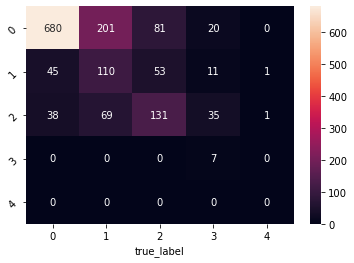

In [172]:
mat_r = confusion_matrix(y_test, y_pred)
sns.heatmap(mat_r.T, annot=True, fmt='g')
pl.xlabel('true_label')
pl.yticks(rotation = 45)

In [173]:
test_rp = classification_report(y_test, y_pred)
print(test_rp)

              precision    recall  f1-score   support

         1.0       0.69      0.89      0.78       763
         2.0       0.50      0.29      0.37       380
         3.0       0.48      0.49      0.49       265
         4.0       1.00      0.10      0.17        73
         5.0       0.00      0.00      0.00         2

    accuracy                           0.63      1483
   macro avg       0.53      0.35      0.36      1483
weighted avg       0.62      0.63      0.59      1483



/Users/lavz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lavz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lavz/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
model = XGBClassifier(n_estimators = 50, objective='softmax', subsample = 0.55,
            max_depth = 5, seed = 10)
model.fit(X_train, y_train)
# make predictions for test data
y_pred_train = model.predict(X_train)
y_pred= model.predict(X_test)
print("Accuracy_test: %.3f%% " % (accuracy_score(y_test, y_pred)*100), 
     "Accuracy_train: %.3f%% " % (accuracy_score(y_train, y_pred_train)*100),
'Overfitting: %.3f%% ' % ((accuracy_score(y_test, y_pred)*100)-(accuracy_score(y_train, y_pred_train)*100)))

Accuracy_test: 62.576%  Accuracy_train: 73.623%  Overfitting: -11.047% 


## Tuning - combing certain groups
There are way less counts of category 5 and 4, so let's combine it with category 3.

In [35]:
combo_mod['CS_4'] = combo_mod['CS_y'].replace(5, 4)
combo_mod['CS_3'] = combo_mod['CS_4'].replace(4, 3)
combo_mod['CS_3'].value_counts()

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


1.0    3068
2.0    1498
3.0    1364
Name: CS_3, dtype: int64

In [38]:
X_3 = combo_mod[['Evap_tavg_',
       'Lwnet_tavg',  'Qair_f_tavg',
        'Qh_tavg', 
       'Qs_tavg',   'Rainf_f_tavg', 
       'SoilMoi00_10cm_tavg', 'Swnet_tavg', 
       'Tair_f_tavg', 'Wind_f_tavg', 'ozone_mean',
       'npp_mean', 'nl_mean']]
y = combo_mod['CS_3']
X_train, X_test, y_train, y_test = train_test_split(X_3, y, test_size=0.25, random_state=12345)

In [176]:
pipeline_rf_gr = Pipeline([('classifier', RandomForestClassifier(random_state = 10))])

rf_params = {'classifier__n_estimators':[20, 50, 100, 200],
        'classifier__criterion':['gini', 'entropy'],
             'classifier__max_depth':[3, 5, 8, 10, 12],
             'classifier__min_samples_split':[2, 5, 8,10],
             'classifier__min_samples_leaf':[2, 5, 8]}
grid_rf = GridSearchCV(pipeline_rf_gr, rf_params, cv=5)

grid_rf.fit(X_train, y_train)

# Mirror Mirror from GridSearch! Tell me what's the best parameters
print(grid_rf.best_params_)

{'classifier__criterion': 'entropy', 'classifier__max_depth': 12, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}


In [14]:
clf=RandomForestClassifier(n_estimators=50, criterion = 'entropy', max_depth=8,
                        min_samples_leaf = 2, min_samples_split = 5,
                          random_state=10)
clf.fit(X_train,y_train)
y_pred_train = clf.predict(X_train)
y_pred=clf.predict(X_test)

In [15]:
print("Accuracy_test: %.3f%% " % (accuracy_score(y_test, y_pred)*100), 
     "Accuracy_train: %.3f%% " % (accuracy_score(y_train, y_pred_train)*100))

Accuracy_test: 64.262%  Accuracy_train: 75.624% 


In [16]:
test_rp = classification_report(y_test, y_pred)
print(test_rp)

              precision    recall  f1-score   support

         1.0       0.68      0.90      0.77       763
         2.0       0.49      0.21      0.29       380
         3.0       0.60      0.56      0.58       340

    accuracy                           0.64      1483
   macro avg       0.59      0.55      0.55      1483
weighted avg       0.61      0.64      0.61      1483



## XGBoost

In [42]:
model = XGBClassifier(n_estimators = 70, objective='softmax', subsample = 0.55,
            max_depth = 4, seed = 10)
model.fit(X_train, y_train)
# make predictions for test data
y_pred_train = model.predict(X_train)
y_pred= model.predict(X_test)
print("Accuracy_test: %.3f%% " % (accuracy_score(y_test, y_pred)*100), 
     "Accuracy_train: %.3f%% " % (accuracy_score(y_train, y_pred_train)*100),
'Overfitting: %.3f%% ' % ((accuracy_score(y_test, y_pred)*100)-(accuracy_score(y_train, y_pred_train)*100)))

Accuracy_test: 67.498%  Accuracy_train: 73.645%  Overfitting: -6.147% 


## KNN

In [322]:
pipe_knn = Pipeline([('classifier',KNeighborsClassifier())])
knn_params = {'classifier__n_neighbors': [3,4,5,6,7,8,9,10,11,12,13, 14]}
grid_knn = GridSearchCV(pipe_knn, knn_params)
grid_knn.fit(X_train, y_train)
test_p_knn = grid_knn.predict(X_test)
test_rp_knn = classification_report(y_test, test_p_knn)
print(test_rp_knn)

              precision    recall  f1-score   support

         1.0       0.65      0.85      0.73       763
         2.0       0.41      0.23      0.30       380
         3.0       0.51      0.40      0.45       340

    accuracy                           0.59      1483
   macro avg       0.52      0.49      0.49      1483
weighted avg       0.55      0.59      0.56      1483



In [323]:
train_p_knn = grid_knn.predict(X_train)
acc_knn_train = accuracy_score(y_train, train_p_knn)
acc_knn_test = accuracy_score(y_test, test_p_knn)
print(acc_knn_train, acc_knn_test, grid_knn.best_params_)

0.627614121879919 0.5866486850977748 {'classifier__n_neighbors': 13}


## TF-Keras

In [315]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[13]),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    
])

In [319]:
model.compile(optimizer='Adamax',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [320]:
model.fit(X_train, y_train, batch_size = 100, epochs=25)

Train on 4447 samples
Epoch 1/25
4447/4447 [==============================] - 0s 64us/sample - loss: 0.8876 - acc: 0.5997
Epoch 2/25
4447/4447 [==============================] - 0s 31us/sample - loss: 0.8837 - acc: 0.5928
Epoch 3/25
4447/4447 [==============================] - 0s 30us/sample - loss: 0.8826 - acc: 0.5939
Epoch 4/25
4447/4447 [==============================] - 0s 30us/sample - loss: 0.8815 - acc: 0.5982
Epoch 5/25
4447/4447 [==============================] - 0s 35us/sample - loss: 0.8821 - acc: 0.5984
Epoch 6/25
4447/4447 [==============================] - 0s 32us/sample - loss: 0.8818 - acc: 0.6000
Epoch 7/25
4447/4447 [==============================] - 0s 29us/sample - loss: 0.8805 - acc: 0.6013
Epoch 8/25
4447/4447 [==============================] - 0s 33us/sample - loss: 0.8798 - acc: 0.5959
Epoch 9/25
4447/4447 [==============================] - 0s 30us/sample - loss: 0.8797 - acc: 0.5973
Epoch 10/25
4447/4447 [==============================] - 0s 37us/sample - loss

In [321]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=3)

print('\nTest accuracy:', test_acc)


Test accuracy: 0.5967633


## Tuning - Combining into 2 categories, 2 and 3

In [43]:
combo_mod['CS_2'] = combo_mod['CS_3'].replace(1, 2)
combo_mod['CS_2'].value_counts()

2.0    4566
3.0    1364
Name: CS_2, dtype: int64

In [44]:
X_3 = combo_mod[['Evap_tavg_',
       'Lwnet_tavg',  'Qair_f_tavg',
        'Qh_tavg', 
       'Qs_tavg',   'Rainf_f_tavg', 
       'SoilMoi00_10cm_tavg', 'Swnet_tavg', 
       'Tair_f_tavg', 'Wind_f_tavg', 'ozone_mean',
       'npp_mean', 'nl_mean']]
y = combo_mod['CS_2']
X_train, X_test, y_train, y_test = train_test_split(X_3, y, test_size=0.25, random_state=12345)

In [17]:
pipeline_rf_gr = Pipeline([('classifier', RandomForestClassifier(random_state = 10))])

rf_params = {'classifier__n_estimators':[20, 50, 100, 200],
        'classifier__criterion':['gini', 'entropy'],
             'classifier__max_depth':[3, 5, 8, 10, 12],
             'classifier__min_samples_split':[2, 5, 8,10],
             'classifier__min_samples_leaf':[2, 5, 8]}
grid_rf = GridSearchCV(pipeline_rf_gr, rf_params, cv=5)

grid_rf.fit(X_train, y_train)

# Mirror Mirror from GridSearch! Tell me what's the best parameters
print(grid_rf.best_params_)

{'classifier__criterion': 'gini', 'classifier__max_depth': 12, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}


In [39]:
clf=RandomForestClassifier(n_estimators= 75, criterion = 'gini', max_depth=8,
                        min_samples_leaf = 3, min_samples_split = 2,
                           
                          random_state=10)
clf.fit(X_train,y_train)
y_pred_train = clf.predict(X_train)
y_pred=clf.predict(X_test)
print("Accuracy_test: %.3f%% " % (accuracy_score(y_test, y_pred)*100), 
     "Accuracy_train: %.3f%% " % (accuracy_score(y_train, y_pred_train)*100), 
"Overfitting: %.3f%% " % ((accuracy_score(y_test, y_pred)*100)-(accuracy_score(y_train, y_pred_train)*100)) )

Accuracy_test: 82.333%  Accuracy_train: 85.046%  Overfitting: -2.713% 


## Feature Importance

In [42]:
df_rf_new = pd.DataFrame({'Keys':X_train.columns,
'Value':clf.feature_importances_}).sort_values(by='Value', ascending=False)
df_rf_new.head(20)


,Keys,Value
11,npp_mean,0.148846
6,SoilMoi00_10cm_tavg,0.143346
3,Qh_tavg,0.112347
1,Lwnet_tavg,0.105717
9,Wind_f_tavg,0.099975
2,Qair_f_tavg,0.082353
5,Rainf_f_tavg,0.073568
8,Tair_f_tavg,0.068605
7,Swnet_tavg,0.065225
10,ozone_mean,0.040291


## XGBoost

In [69]:
model = XGBClassifier(n_estimators = 70, objective='binary:logistic', subsample = 0.55,
            max_depth = 3, seed = 10)
model.fit(X_train, y_train)
# make predictions for test data
y_pred_train = model.predict(X_train)
y_pred= model.predict(X_test)
print("Accuracy_test: %.3f%% " % (accuracy_score(y_test, y_pred)*100), 
     "Accuracy_train: %.3f%% " % (accuracy_score(y_train, y_pred_train)*100),
'Overfitting: %.3f%% ' % ((accuracy_score(y_test, y_pred)*100)-(accuracy_score(y_train, y_pred_train)*100)))

Accuracy_test: 83.682%  Accuracy_train: 83.067%  Overfitting: 0.614% 


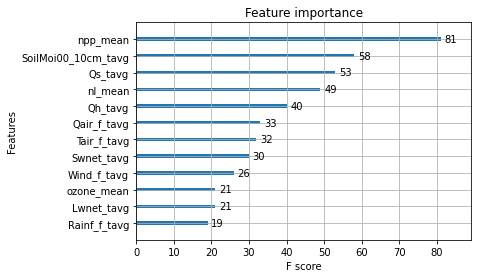

In [70]:
xgboost.plot_importance(model, max_num_features=18)

## Permutation Importance

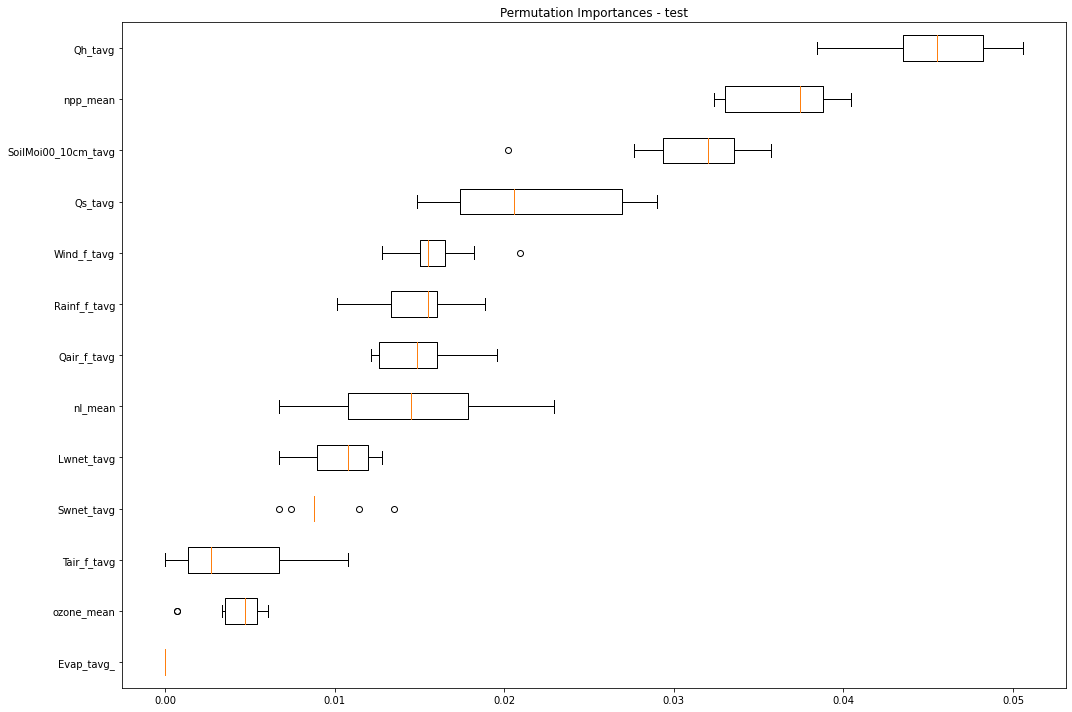

In [74]:
result = permutation_importance(model, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(15, 10))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances - test")
fig.tight_layout()